In [55]:
import numpy as np

train_data = np.load('train_data.npy')
print(train_data.shape)

(3696,)


In [82]:
dev_data = np.load('dev_data.npy')
print(dev_data.shape)

(400,)


In [83]:
test_data = np.load('test_data.npy')
print(test_data.shape)

(192,)


In [96]:
l = []
with open('phone-48.txt','r') as f:
    for line in f:
        l.append(line[:-1])

In [129]:
test_data_27 = np.load('test_data_27.npy')
print(test_data_27.shape)

(192,)


In [150]:
import scipy

In [151]:
mat = scipy.io.loadmat('Logmel_normalized_48Label_Framealigned.mat')
test_data_mat = mat['test']
test_len = mat['testlen']
test_dict = mat['test_dict']

In [161]:
test_len[0][0]

338

In [162]:
test_data_338 = test_data_mat[:test_len[0][0]]

In [100]:

for i in range(0,len(l)-3,4):
    print('|'+ l[i] + '|' + str(i) + '|' + l[i+1] + '|'+str(i+1) +'|'+ l[i+2] + '|'+str(i+2) +'|'+ l[i+3] + '|'+str(i+3) +'|')

|aa|0|ae|1|ah|2|ao|3|
|aw|4|ax|5|ay|6|b|7|
|ch|8|d|9|dh|10|dx|11|
|eh|12|el|13|en|14|epi|15|
|er|16|ey|17|f|18|g|19|
|hh|20|ih|21|ix|22|iy|23|
|jh|24|k|25|l|26|m|27|
|n|28|ng|29|ow|30|oy|31|
|p|32|q|33|r|34|s|35|
|sh|36|sil|37|t|38|th|39|
|cl|40|uh|41|uw|42|v|43|
|vcl|44|w|45|y|46|z|47|


## Convert filterbank back to voice

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
PLOT_CONFIG = { 'interpolation': "nearest", 'aspect': "auto", 'cmap': "Greys" }

from IPython.display import Audio

import soundfile as sf
import numpy as np

from numpy.fft import ifft
from scipy.fftpack import dct, idct

from collections import defaultdict
from copy import deepcopy
from glob import glob

In [104]:
def pre_emphasis(x):
    """
    Applies pre-emphasis step to the signal.
    - balance frequencies in spectrum by increasing amplitude of high frequency 
    bands and decreasing the amplitudes of lower bands
    - largely unnecessary in modern feature extraction pipelines
    ------
    :in:
    x, array of samples
    ------
    :out:
    y, array of samples
    """
    y = np.append(x[0], x[1:] - 0.97 * x[:-1])
    
    return y
    
def hamming(n):
    """
    Hamming method for weighting components of window.
    Feel free to implement more window functions.
    ------
    :in: 
    n, window size
    ------
    :out: 
    win, array of weights to apply along window
    """
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(n) / (n - 1))
    
    return win
    
def windowing(x, size, step):
    """
    Window and stack signal into overlapping frames.
    ------
    :in:
    x, array of samples
    size, window size in number of samples (Note: this may need to be a power of 2)
    step, window shift in number of samples
    ------
    :out:
    frames, 2d-array of frames with shape (number of windows, window size)
    """
    xpad = np.append(x, np.zeros((size - len(x) % size)))
    
    T = (len(xpad) - size) // step
    frames = np.stack([xpad[t * step:t * step + size] for t in range(T)])
    
    return frames
    
def discrete_fourier_transform(x):
    """
    Compute the discrete fourier transform for each frame of windowed signal x.
    Typically, we talk about performing the DFT on short-time windows
    (often referred to as the Short-Time Fourier Transform). Here, the input
    is a 2d-array with shape (window size,  number of windows). We want to
    perform the DFT on each of these windows.
    Note: this can be done in a vectorized form or in a loop.
    --------
    :in: 
    x, 2d-array of frames with shape (window size, number of windows)
    --------
    :out:
    X, 2d-array of complex spectrum after DFT applied to each window of x
    """
    
    # TODO: Implement DFT
    fft_size = x.shape[0]
    j = np.arange(fft_size)
    i = j.reshape((fft_size, 1))
    M = np.exp(-2j * np.pi * i * j / fft_size)
    X = np.dot(M,x)
    return X

    
def fast_fourier_transform(x):
    """
    Fast-fourier transform. Effiicient algorithm for computing the DFT.
    --------
    :in: 
    x, 2d-array of frames with shape (window size, number of windows)
    --------
    :out:
    X, 2d-array of complex spectrum after DFT applied to each window of x
    """
    fft_size = len(x)

    if fft_size <= 16:
        X = discrete_fourier_transform(x)
    
    else:
        indices = np.arange(fft_size)
        even = fast_fourier_transform(x[::2])
        odd = fast_fourier_transform(x[1::2])
        m = np.exp(-2j * np.pi * indices / fft_size).reshape(-1, 1)
        X = np.concatenate([even + m[:fft_size // 2] * odd, even + m[fft_size // 2:] * odd])
    
    return X


def mel_filterbank(nfilters, fft_size, sample_rate):
    """
    Mel-warping filterbank.
    You do not need to edit this code; it is needed to contruct the mel filterbank
    which we will use to extract features.
    --------
    :in: 
    nfilters, number of filters
    fft_size, window size over which fft is performed
    sample_rate, sampling rate of signal
    --------
    :out:
    mel_filter, 2d-array of (fft_size / 2, nfilters) used to get mel features
    mel_inv_filter, 2d-array of (nfilters, fft_size / 2) used to invert
    melpoints, 1d-array of frequencies converted to mel-scale
    """
    freq2mel = lambda f: 2595. * np.log10(1 + f / 700.)
    mel2freq = lambda m: 700. * (10**(m / 2595.) - 1)

    lowfreq = 0
    highfreq = sample_rate // 2

    lowmel = freq2mel(lowfreq)
    highmel = freq2mel(highfreq)

    melpoints = np.linspace(lowmel, highmel, 1 + nfilters + 1)

    # must convert from freq to fft bin number
    fft_bins = ((fft_size + 1) * mel2freq(melpoints) // sample_rate).astype(np.int32)

    filterbank = np.zeros((nfilters, fft_size // 2))
    for j in range(nfilters):
        for i in range(fft_bins[j], fft_bins[j + 1]):
            filterbank[j, i] = (i - fft_bins[j]) / (fft_bins[j + 1] - fft_bins[j])
        for i in range(fft_bins[j + 1], fft_bins[j + 2]):
            filterbank[j, i] = (fft_bins[j + 2] - i) / (fft_bins[j + 2] - fft_bins[j + 1])

    mel_filter = filterbank.T / filterbank.sum(axis=1).clip(1e-16)
    mel_inv_filter = filterbank

    return mel_filter, mel_inv_filter, melpoints
    
    
def inv_spectrogram(X_s, size, step, n_iter=15):
    """
    Feel free to disregard this code. It is not necessary that
    you follow the code below, but it can be used to invert
    from the spectrogram (signal spectrum magnitude) back to the signal
    which can be helpful when qualitatively assessing the nature of
    compression into MFCC features.
    """
    
    def find_offset(a, b):
        corrs = np.convolve(a - a.mean(), b[::-1] - b.mean())
        corrs[:len(b) // 2] = -1e12
        corrs[-len(b) // 2:] = -1e12
        return corrs.argmax() - len(a)

    def iterate(X, iteration):
        T, n = X.shape
        size = n // 2

        x = np.zeros((T * step + size))
        window_sum = np.zeros((T * step + size))

        est_start = size // 2 - 1
        est_stop = est_start + size

        for t in range(T):
            x_start = t * step
            x_stop = x_start + size

            est = ifft(X[t].real + 0j if iteration == 0 else X[t]).real[::-1]            
            if t > 0 and x_stop - step > x_start and est_stop - step > est_start:
                offset = find_offset(x[x_start:x_stop - step], est[est_start:est_stop - step])
            else:
                offset = 0
                
            x[x_start:x_stop] += est[est_start - offset:est_stop - offset] * hamming(size)
            window_sum[x_start:x_stop] += hamming(size)

        return x.real / window_sum.clip(1e-12)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    reg = np.max(X_s) / 1e8

    X_best = iterate(deepcopy(X_s), 0)
    for i in range(1, n_iter):
        X_best = windowing(X_best, size, step) * hamming(size)
        est = fast_fourier_transform(X_best.T).T
        phase = est / np.maximum(reg, np.abs(est))
        X_best = iterate(X_s * phase[:len(X_s)], i)
    
    return np.real(X_best)

In [163]:
mfcc = test_data_338[0][0]

In [164]:
label = mfcc[:,-1]
mfcc = mfcc[:,:-1]

IndexError: invalid index to scalar variable.

In [141]:
size = len(mfcc[0])
nfilters = len(mfcc)
fs = 8000

In [142]:
mel_filter, mel_inv_filter, melpoints = mel_filterbank(nfilters, size, fs)

In [143]:
# invert from MFCCs back to waveform
recovered_log_mel_fbank = idct(mfcc, type=2, n=nfilters, axis=1, norm='ortho')

# exponentiate log and invert mel warping
recovered_power = (10**recovered_log_mel_fbank).dot(mel_inv_filter)

# invert mel warping of spectrogram
recovered_magnitude = np.sqrt(recovered_power * size)

In [144]:
recovered_magnitude.shape

(27, 60)

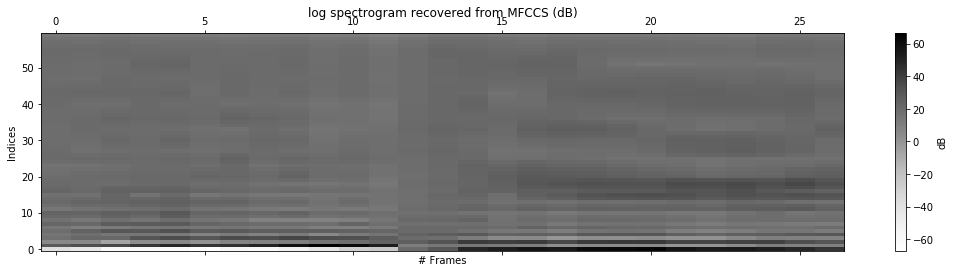

In [145]:
# Look at specgram
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(18,4))
cax = ax.matshow(20*np.log10(recovered_magnitude.clip(1e-12)).T, origin='lower', **PLOT_CONFIG)
fig.colorbar(cax, label='dB')
plt.title('log spectrogram recovered from MFCCS (dB)')
plt.xlabel('# Frames')
plt.ylabel('Indices')

In [123]:
print(size)

120


In [149]:
step = size // 2 # distance to slide along the window in time
recovered_signal = inv_spectrogram(recovered_magnitude, size, step)
Audio(data=recovered_signal, rate=fs)

In [170]:
np.exp(mfcc)

array([[ 0.08791191,  0.17652725,  0.18840149, ...,  1.04915292,
         1.16655855,  1.31470065],
       [ 0.13212855,  0.13392438,  0.18840149, ...,  1.07526313,
         1.07057962,  1.18904207],
       [ 0.1493071 ,  0.16313128,  0.21023906, ...,  1.11977302,
         1.02071361,  0.92710514],
       ..., 
       [ 0.12178842,  0.11437188,  0.11713478, ...,  0.84610484,
         0.85266546,  0.97260669],
       [ 0.06345908,  0.09767301,  0.10119864, ...,  0.99881933,
         1.0604158 ,  1.05074843],
       [ 0.22440115,  0.15682104,  0.13557911, ...,  1.09661855,
         1.16179823,  0.98928314]])

In [174]:
mfcc = test_data_338
#mfcc = np.exp(mfcc)
size = len(mfcc[0])
nfilters = len(mfcc)
fs = 8000

mel_filter, mel_inv_filter, melpoints = mel_filterbank(nfilters, size, fs)

# invert from MFCCs back to waveform
recovered_log_mel_fbank = idct(mfcc, type=2, n=nfilters, axis=1, norm='ortho')

# exponentiate log and invert mel warping
recovered_power = (10**recovered_log_mel_fbank).dot(mel_inv_filter)

# invert mel warping of spectrogram
recovered_magnitude = np.sqrt(recovered_power * size)

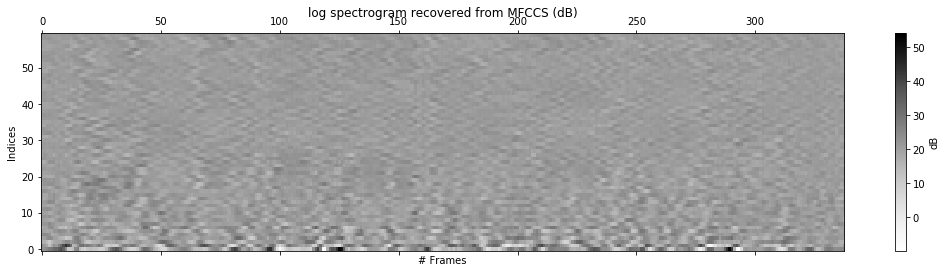

In [175]:
# Look at specgram
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(18,4))
cax = ax.matshow(20*np.log10(recovered_magnitude.clip(1e-12)).T, origin='lower', **PLOT_CONFIG)
fig.colorbar(cax, label='dB')
plt.title('log spectrogram recovered from MFCCS (dB)')
plt.xlabel('# Frames')
plt.ylabel('Indices')

In [176]:
step = size // 2 # distance to slide along the window in time
recovered_signal = inv_spectrogram(recovered_magnitude, size, step)
Audio(data=recovered_signal, rate=fs)